In [1]:
from new_examples.testgraph import Ein, Eout, Rin
from graph.graphutils import draw_graph_graphical_props, flat_graph_formulation, sources

# Typed Graph (Flat Formulation graph)

This is a graph where each node is assigned the type of variable, component or solver

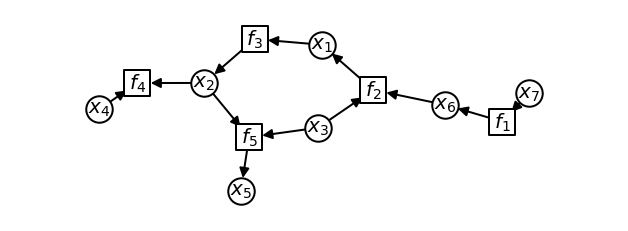

In [2]:
G = flat_graph_formulation(Ein, Eout, Rin)
draw_graph_graphical_props(G, prog='sfdp', figsize=(11,4))

# From random example

In [4]:
from testproblems import generate_random_prob
from collections import OrderedDict
from operators import sort_scc, reorder_merge_solve
from nestedgraph import build_typedgraph
from workflow import generate_workflow
from graphutils import merge_edges

In [80]:
n_eqs = 7
n_vars = 10
seed = 42#8 is triang#seed 10 is nice
sparsity = .8#1.1 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
Ein = {key: tuple(vr-n_eqs for vr in var if vr !=dout[key]) for key,var in eqv.items()}
Eout = {key: (var-n_eqs,) for key,var in dout.items()}
Rin = dict()
Ftree=OrderedDict((idx,1) for idx in range(n_eqs))
Stree=dict()
Vtree=dict()
edges = Ein, Eout, Rin
tree = Ftree, Stree, Vtree

In [132]:
all_vars = all_variables(Ein,Eout)

In [81]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)

In [82]:
merge_order

[{f_1}, {f_2}, {f_5}, {f_0, f_3, f_4, f_6}]

In [83]:
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [84]:
ntree

(OrderedDict([(1, 1), (2, 1), (5, 1), (4, 2), (0, 2), (6, 2), (3, 2)]),
 {2: 1},
 {4: 2, 3: 2, 0: 2, 5: 2})

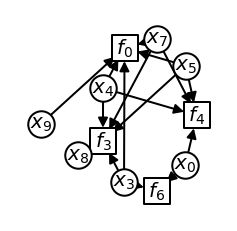

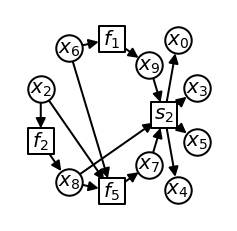

In [85]:
graphs = build_typedgraph(nedges, ntree)
for key,graph in graphs.items():
    draw_graph_graphical_props(graph, {}, prog='circo', figsize=(4,4))

## Workflow resolve

In [86]:
# Interface:
# addsolver(mdao, parent, solver_name) # adds a group and attaches a solver to it
# addimpcomp(mdao, parent, component_name, [(input_names, output_name, fx, gradfx, guess_vars)]) # adds an implicit solver for residuals
# addexpcomp(mdao, parent, component_name, (input_names, output_name, fx, gradfx)) # adds an explicit solver

In [131]:
from graphutils import all_components, end_components, Node, COMP, SOLVER, VAR, solver_children, make_nodetype, all_variables
from workflow import path
from enum import Enum
from utils import normalize_name
from collections import namedtuple

In [88]:
ExecutionTypes = Enum('ExecutionTypes', 'EXPL IMPL EQCST SOLVE OPT')
ExecutionTypes.__repr__ = lambda x: x.name
EXPL, IMPL, EQCST, SOLVE, OPT = ExecutionTypes.EXPL,ExecutionTypes.IMPL,ExecutionTypes.EQCST,ExecutionTypes.SOLVE,ExecutionTypes.OPT

In [89]:
Component = namedtuple('COMPONENT', ['inputs', 'component', 'outputs', 'function']) 

In [90]:
eqv

{0: (11, 12, 14, 16, 10),
 1: (13, 16),
 2: (9, 15),
 3: (10, 11, 14, 15, 12),
 4: (7, 11, 12, 14),
 5: (9, 13, 15, 14),
 6: (10, 7)}

In [91]:
from randompoly import random_bijective_polynomial
from compute import Var, reassigneq
import numpy as np
import sympy as sp
from execution import Component

In [137]:
varsympy = {idx: Var(str(Node(idx,VAR)), varid=idx) for idx in all_vars}

In [93]:
rng = np.random.default_rng(12345)
polynomials = {idx: random_bijective_polynomial(rng, (varsympy[elt-n_eqs] for elt in vrs)) for idx,vrs in eqv.items()}

In [94]:
polynomials

{0: -0.3*x_3*x_4*x_9 + 0.2*x_5*x_7 - 0.6,
 1: 0.3*x_6*x_9 + 0.9,
 2: 0.9*x_2*x_8 + 0.3,
 3: 0.8*x_3*x_7 + 0.5*x_4 - 0.3*x_5*x_8 - 0.6,
 4: -0.1*x_0*x_7 - 0.3*x_4*x_5 - 0.5,
 5: -0.7*x_2*x_8 - 0.8*x_6*x_7 + 0.2,
 6: 0.2*x_0*x_3 + 0.9}

In [133]:
arg_mapping = {idx:str(Node(idx,VAR)) for idx in all_vars}

In [96]:
fcomps = [Component.fromsympy(function, component=component, arg_mapping=arg_mapping) for component,function in polynomials.items()]

In [97]:
for idx, eq in polynomials.items():
    left = dout[idx]-n_eqs
    leftvar = varsympy[left]
    function = sp.simplify(reassigneq(None, eq, leftvar))
    new_comp = Component.fromsympy(function, leftvar, component=idx, arg_mapping=arg_mapping)
    fcomps.append(new_comp)

In [98]:
fcomps

[((5, 3, 7, 9, 4), 0, (None,), '-0.3*x_3*x_4*x_9 + 0.2*x_5*x_7 - 0.6'),
 ((9, 6), 1, (None,), '0.3*x_6*x_9 + 0.9'),
 ((8, 2), 2, (None,), '0.9*x_2*x_8 + 0.3'),
 ((5, 8, 3, 7, 4), 3, (None,), '0.8*x_3*x_7 + 0.5*x_4 - 0.3*x_5*x_8 - 0.6'),
 ((0, 5, 7, 4), 4, (None,), '-0.1*x_0*x_7 - 0.3*x_4*x_5 - 0.5'),
 ((8, 7, 6, 2), 5, (None,), '-0.7*x_2*x_8 - 0.8*x_6*x_7 + 0.2'),
 ((0, 3), 6, (None,), '0.2*x_0*x_3 + 0.9'),
 ((5, 7, 9, 4), 0, (3,), '(0.666666666666667*x_5*x_7 - 2.0)/(x_4*x_9)'),
 ((6,), 1, (9,), '-3.0/x_6'),
 ((2,), 2, (8,), '-0.333333333333333/x_2'),
 ((3, 7, 8, 4), 3, (5,), '(2.66666666666667*x_3*x_7 + 1.66666666666667*x_4 - 2.0)/x_8'),
 ((0, 5, 7), 4, (4,), '-(0.333333333333333*x_0*x_7 + 1.66666666666667)/x_5'),
 ((6, 8, 2), 5, (7,), '(-0.875*x_2*x_8 + 0.25)/x_6'),
 ((3,), 6, (0,), '-4.5/x_3')]

In [99]:
# f = {
#     ((1,2,3,4,5),0,(None,),'eq0'),
#     ((0,1,3,4,5),3,(None,),'eq3'),
#     ((1,5,),1,(6,),'eq1'),
#     ((4,5,7),2,(0,),'eq2')
# }
# f = {Component(*comp) for comp in f}

In [101]:
Fend = end_components(nedges[1])
nFtree, nStree, nVtree = ntree
nEin, nEout, nRin = nedges
nEin = merge_edges(nEin, nRin)

In [100]:
def get_f(f, edges):
    f_lookup = {(frozenset(elt.inputs),elt.component,frozenset(elt.outputs)): elt for elt in f}
    Ein = merge_edges(edges[0], edges[2])
    Eout = edges[1]
    def lookup(comp):
        key = (frozenset(Ein[comp]),comp,frozenset(Eout[comp]))
        return f_lookup[key] 
    return lookup

In [107]:
lookup_f = get_f(fcomps, nedges)

In [102]:
# x_4,x_5,x_7 = [varsympy[idx] for idx in [4,5,7]]
# right = -8.0*x_4*x_5*x_7 + 8.0
# tovar = varsympy[0]
# symb_order= list(right.free_symbols)
# fx = sp.lambdify(symb_order, right)
# from unitutils import unit_conversion_factors
# convert, factor = unit_conversion_factors(right, tovar.varunit, symb_order)
# fx(*convert*np.array([1,2,3]).flatten())/factor
# lookup_f = get_f(fcomps, nedges)
# lookup_f(2).evaldict({'x_4':1.,'x_5':1., 'x_7': 2.})

In [103]:
def addexpcomp_args(lookup_f, parent_solver_node, key):
    component = lookup_f(key)
    input_names = [str(Node(inputvar,VAR)) for inputvar in component.inputs]
    output_names = [str(Node(outputvar, VAR)) for outputvar in component.outputs]
    args = (EXPL, str(parent_solver_node), str(Node(key, COMP)), input_names, output_names[0], component.evaldict, component.graddict)
    return args

In [104]:
def implicit_comp_name(comps):
    return "res_{}".format('_'.join(map(lambda x: normalize_name(str(x)),comps)))

In [105]:
def addimpcomp_args(lookup_f, parent_solver_node, fends, output_names):
    impl_components = []
    comps = []
    for idx, comp_node in enumerate(fends):
        component = lookup_f(comp_node)
        input_names = [str(Node(inputvar,VAR)) for inputvar in component.inputs]
        output_name = str(Node(output_names[idx], VAR)) #TODO: THIS IS VERY HACKY BUT WILL WORK FOR NOW
        impl_components.append((input_names, output_name, component.evaldict, component.graddict, 1.))
        comps.append(Node(comp_node, COMP))
    args = (str(parent_solver_node), implicit_comp_name(comps), impl_components)
    return args

In [108]:
visited = set()
workflow = []
nFtree_copy = OrderedDict(nFtree)
flag = False
while nFtree_copy:
    key, parentsolver = nFtree_copy.popitem(last=False)
    parent_solver_node = Node(parentsolver,SOLVER)
    out = path(nStree, parentsolver, visited)
    out_rev = out[::-1]
    visited = visited.union(out)
    f = [elt for elt in solver_children(nFtree_copy, parentsolver) if elt in Fend]
    for solver_idx in out_rev:
        parent_solver = nStree.get(solver_idx, None)
        parent_solver_name = str(Node(parent_solver,SOLVER)) if parent_solver else None
        workflow.append((SOLVE, parent_solver_name, str(Node(solver_idx, SOLVER))))
    if key in Fend and not f: #the last one
        fends = [elt for elt in solver_children(nFtree, parentsolver) if elt in Fend]
        args = addimpcomp_args(lookup_f, parent_solver_node, fends, list(solver_children(nVtree, parentsolver)))
        if not flag:
            workflow.append((IMPL, *args))
        else:
            workflow.append((EQCST, *args)) #this would add them as design variable
    elif key not in Fend: 
        args = addexpcomp_args(lookup_f, parent_solver_node, key)
        workflow.append(args)

In [109]:
workflow

[(SOLVE, None, 's_1'),
 (EXPL,
  's_1',
  'f_1',
  ['x_6'],
  'x_9',
  <bound method Component.evaldict of ((6,), 1, (9,), '-3.0/x_6')>,
  <bound method Component.graddict of ((6,), 1, (9,), '-3.0/x_6')>),
 (EXPL,
  's_1',
  'f_2',
  ['x_2'],
  'x_8',
  <bound method Component.evaldict of ((2,), 2, (8,), '-0.333333333333333/x_2')>,
  <bound method Component.graddict of ((2,), 2, (8,), '-0.333333333333333/x_2')>),
 (EXPL,
  's_1',
  'f_5',
  ['x_6', 'x_8', 'x_2'],
  'x_7',
  <bound method Component.evaldict of ((6, 8, 2), 5, (7,), '(-0.875*x_2*x_8 + 0.25)/x_6')>,
  <bound method Component.graddict of ((6, 8, 2), 5, (7,), '(-0.875*x_2*x_8 + 0.25)/x_6')>),
 (SOLVE, 's_1', 's_2'),
 (IMPL,
  's_2',
  'res_f4_f0_f6_f3',
  [(['x_0', 'x_5', 'x_7', 'x_4'],
    'x_4',
    <bound method Component.evaldict of ((0, 5, 7, 4), 4, (None,), '-0.1*x_0*x_7 - 0.3*x_4*x_5 - 0.5')>,
    <bound method Component.graddict of ((0, 5, 7, 4), 4, (None,), '-0.1*x_0*x_7 - 0.3*x_4*x_5 - 0.5')>,
    1.0),
   (['x_5',

# Build problem

In [110]:
from buildexecution import addexpcomp, addimpcomp, addsolver
from compute import buildidpvars
import openmdao.api as om

In [111]:
architecture_mappings = {
        EXPL: addexpcomp,
        IMPL: addimpcomp,
        SOLVE: addsolver
    }

In [112]:
prob = om.Problem()
mdo_model = prob.model
groups = {None:mdo_model}

mdao_in = {Node(elt, VAR) for elt in sources(nEin, nEout)-nVtree.keys()}

In [113]:
buildidpvars(mdao_in, mdo_model)

In [114]:
# This next step actually builds all the openMDAO components
for comp_type, *comp_args in workflow:
    #print(comp_type, comp_args[:3])
    architecture_mappings[comp_type](groups, *comp_args)

In [115]:
prob.setup();

In [116]:
#om.n2(mdo_model)

In [117]:
prob.get_val('x_2')

array([0.22199317])

In [118]:
prob.run_model();


===
s_1
===
+  
+  =======
+  s_1.s_2
+  =======
+  NL: Newton Converged in 5 iterations
+  
+  =======
+  s_1.s_2
+  =======
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations


## Validate answer

In [119]:
from executeformulations import extractvals

In [120]:
fcomps_res = [comp for comp in fcomps if comp.outputs == (None,)]

In [127]:
#mdo_model.list_inputs()

In [136]:
varsympy

{0: x_0,
 1: x_1,
 2: x_2,
 3: x_3,
 4: x_4,
 5: x_5,
 6: x_6,
 7: x_7,
 8: x_8,
 9: x_9}

In [138]:
outs = extractvals(prob, varsympy)

In [139]:
[elt.evaldict(outs) for elt in fcomps_res]


[2.220446049250313e-16,
 1.1102230246251565e-16,
 2.7755575615628914e-16,
 -1.1102230246251565e-16,
 0.0,
 -2.7755575615628914e-17,
 -1.1102230246251565e-16]